In [62]:
import numpy as np
from tools.ObjectDetector import Detector
from matplotlib import pyplot as plt
import cv2

In [63]:
image_path = 'samples/2A_back_grape.jpg'
detector = Detector('../runs/detect/train3/weights/best.pt')
result = detector.inference(image_path)
box_dict = detector.get_all_boxes(result)


0: 640x480 1 grape_cluster, 1 index, 1 measure_label, 68.3ms
Speed: 3.0ms preprocess, 68.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


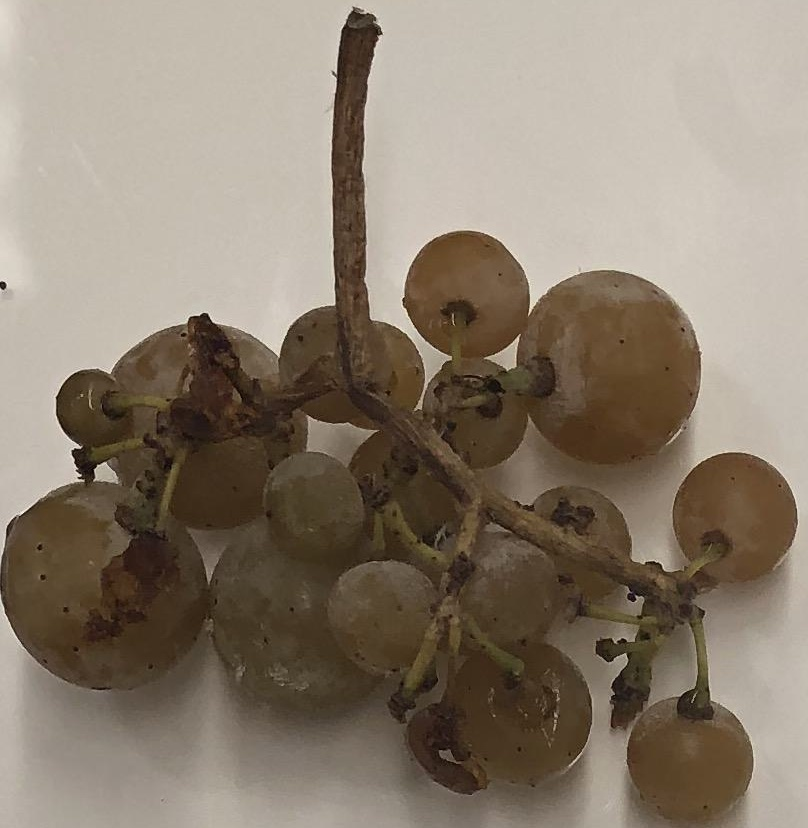

In [64]:

image = cv2.imread(image_path)

# 定义bbox的坐标，格式为 [x1, y1, x2, y2]
bbox = list(box_dict['grape_cluster'])
# 使用数组切片操作提取bbox区域
x1, y1, x2, y2 = bbox
cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
# 显示裁剪后的图像
cv2.imwrite('{path}_cropped.jpg'.format(path = image_path), cropped_image)

from IPython.display import Image, display

display(Image(filename='{path}_cropped.jpg'.format(path = image_path)))

In [65]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_anns(anns):
    if len(anns) == 0:
        return

    # Convert the tensors to numpy arrays and sort them
    np_anns = [ann.numpy() for ann in anns]
    sorted_anns = sorted(np_anns, key=lambda x: np.sum(x), reverse=True)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Initialize an image with transparency
    img = np.ones((sorted_anns[0].shape[0], sorted_anns[0].shape[1], 4))
    img[:, :, 3] = 0
    
    i = 0
    for ann in sorted_anns:
        # Create a random color mask with transparency
        color_mask = np.concatenate([np.random.random(3), [0.35]])

        # Apply the mask to the annotation areas
        img[ann.astype(bool)] = color_mask
        
        # add text
        text = str(i)
        ys, xs = np.where(ann)
        centroid = (np.mean(xs), np.mean(ys))
        ax.scatter(centroid[0], centroid[1], color='green', marker='.', s=50, edgecolor='white', linewidth=1.25)    
        # ax.text(centroid[0], centroid[1], text, color='white', ha='center', va='center')
        # i += 1
        
    ax.imshow(img)

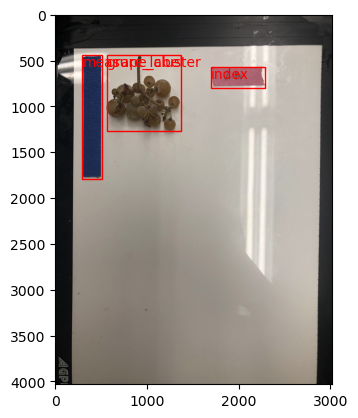

<Figure size 4000x4000 with 0 Axes>

In [66]:
detector.plt_all_boxes(image_path, box_dict)

In [67]:
from tools.Segmentator import Segmentator

GrapeSegmenter = Segmentator(model_path='./FastSAM/weights/FastSAM-x.pt', DEVICE='cpu')
prompt_process= GrapeSegmenter.start(image_path)
ann_everything = GrapeSegmenter.seg_everything(prompt_process)
len(ann_everything)


image 1/1 E:\Dev\GrapeYOLO\samples\2A_back_grape.jpg: 1024x768 27 objects, 2119.5ms
Speed: 8.5ms preprocess, 2119.5ms inference, 1249.4ms postprocess per image at shape (1, 3, 1024, 1024)


27

In [53]:
import torch
# 计算每个tensor的总和
sums = [ann.sum().item() for ann in ann_everything]

# 找出总和最大的tensor
max_sum_index = sums.index(max(sums))

# 从列表中移除这个tensor
ann_everything_without_max = torch.cat((ann_everything[:max_sum_index], ann_everything[max_sum_index + 1:]))
len(ann_everything_without_max)

20

In [54]:
grape_whole_ann = ann_everything_without_max.sum(dim=0)
result_tensor = torch.clamp(grape_whole_ann, max=1)

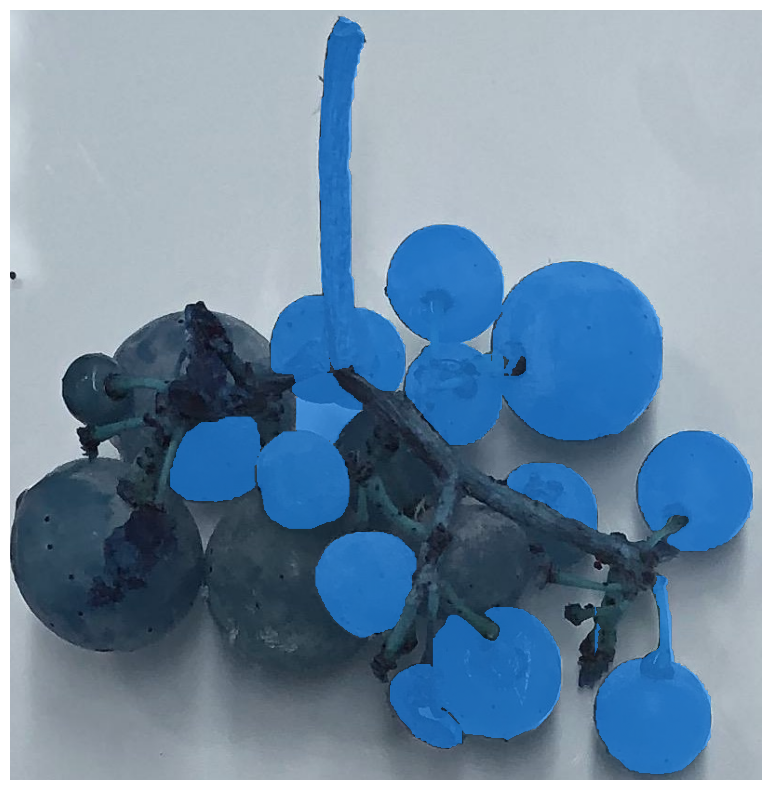

In [57]:
image = cv2.imread('{path}_cropped.jpg'.format(path = image_path))
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(result_tensor, plt.gca())
# show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 

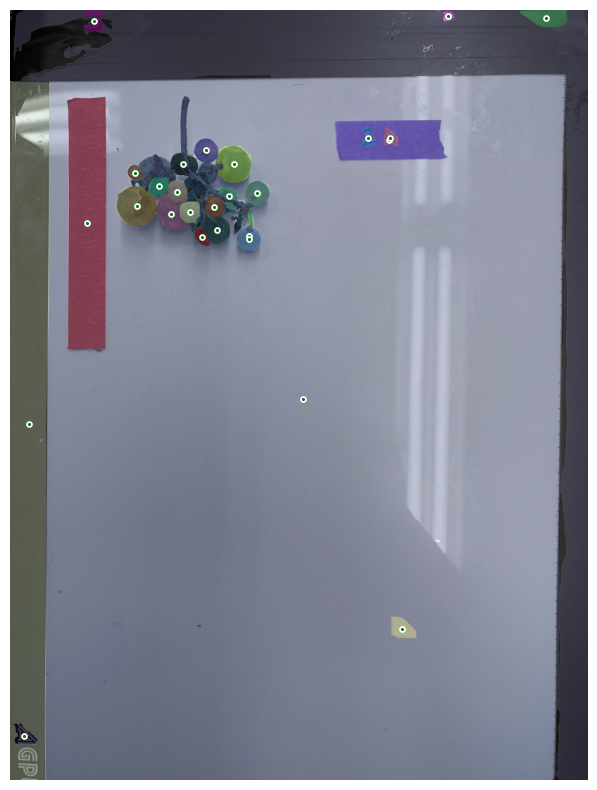

In [69]:
image = cv2.imread(image_path)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(ann_everything)
# show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 